<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li><li><span><a href="#LightGBMRegressor" data-toc-modified-id="LightGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Описание проекта**
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.
Инструкция по выполнению проекта
 * Загрузите данные и выполните их ресемплирование по одному часу.
 * Проанализируйте данные.
 * Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
 * Проверьте данные на тестовой выборке и сделайте выводы.
 
**Описание данных**
Данные лежат в файле /datasets/taxi.csv. Скачать датасет. 
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
import lightgbm as lgb
import time
import warnings
warnings.filterwarnings('ignore')
import numpy as np
RANDOM_STATE = 12345

Прочитаем файл в датафрейм, назначив даты индексом

In [2]:
df = pd.read_csv('/datasets/db.csv', index_col=[0], parse_dates=[0])

Посмотрим первые строки фрейма и общую информацию

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, есть ли пропуски

In [5]:
df.isna().sum()

num_orders    0
dtype: int64

Проверим индекс на монотонность

In [6]:
df.index.is_monotonic

True

Ресемплируем данные по часу

In [7]:
df = df.resample('1H').sum()

In [8]:
for column in df.columns:
       print(f"Уникальные значения в столбце {column}:")
       print(df[column].value_counts())

Уникальные значения в столбце num_orders:
73     65
66     58
57     58
78     54
84     52
       ..
210     1
214     1
238     1
242     1
295     1
Name: num_orders, Length: 251, dtype: int64


In [9]:
print(df.describe())

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


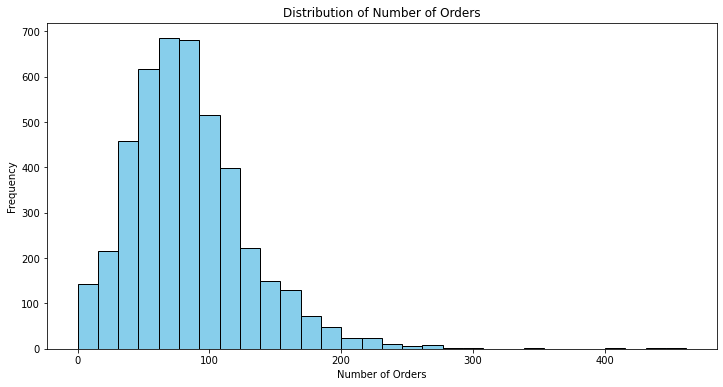

In [10]:
plt.figure(figsize=(12, 6))
plt.hist(df['num_orders'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Orders')
plt.show()

In [12]:
df.duplicated().sum()


4165

## Анализ

In [8]:
def draw(data, col):
    Q1 = np.quantile(data[col], 0.25, interpolation='midpoint')
    Q3 = np.quantile(data[col], 0.75, interpolation='midpoint')
    IQR = Q3 - Q1
    
    plt.figure(figsize=(15,.5))
    sns.boxplot(data[col]).set(xlim = [Q1-3*(Q3-Q1), Q3+3*(Q3-Q1)])
    plt.show()
    
    plt.figure(figsize=(15,3))
    sns.distplot(data[col])
    plt.show()

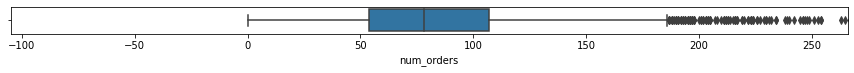

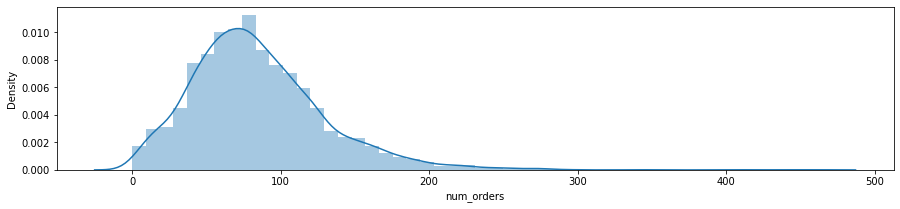

In [9]:
draw(df, 'num_orders')

In [10]:
# найдем значение квантилей
q1 = int(df['num_orders'].quantile([0.25]))
q3 = int(df['num_orders'].quantile([0.75]))
print((q1), (q3))

54 107


In [11]:
# найдем межквартильное расстояние
iqr = q3 - q1
iqr

53

In [12]:
# Найдем правый край Усов
q_moustache = q3 + 1.5*iqr
q_moustache


186.5

In [13]:
# посмотрим на выбросы в датафрейме
df[df['num_orders'] > q_moustache].tail(30)

,num_orders
datetime,
2018-08-28 00:00:00,192
2018-08-28 09:00:00,195
2018-08-28 17:00:00,211
2018-08-28 21:00:00,189
2018-08-29 00:00:00,234
2018-08-29 14:00:00,196
2018-08-29 16:00:00,220
2018-08-29 20:00:00,191
2018-08-29 23:00:00,265


In [14]:
df[df['num_orders'] > 300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


Судя по графику, большинство этих значений вполне естественно вписываются во временной ряд. А в список выбросов они попали из-за того что находятся в конце временного ряда, у которого есть положительный тренд. Поэтому принято решение не удалять выбросы.

Разложим временной ряд на тренд и сезонную составляющие с помощью функции

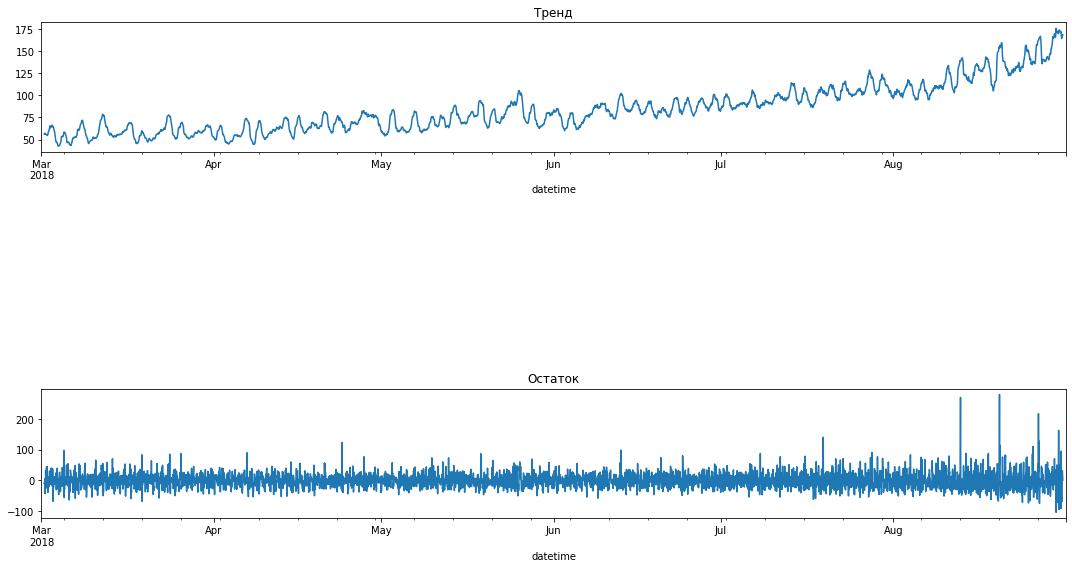

In [15]:
decomposed = seasonal_decompose(df)
 
plt.figure(figsize=(15, 8)) 
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
#plt.subplot(312)
#decomposed.seasonal.plot(ax=plt.gca())
#plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

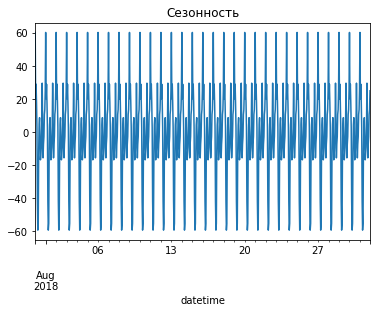

In [16]:
decomposed.seasonal['2018-07-31':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.show()

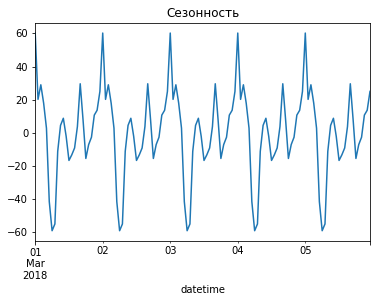

In [17]:
decomposed.seasonal['2018-03-01':'2018-03-05'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.show()

Проверим, к какому типу принадлежит наш временной ряд

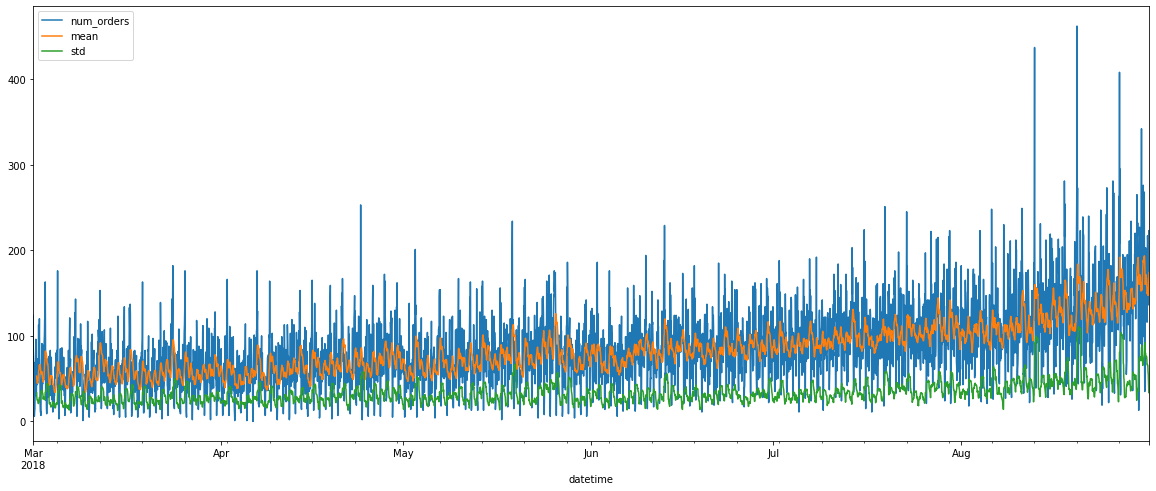

In [18]:
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot(figsize=(20,8));

Скользящее среднее отклонение со временем изменяеся не слишком сильно. При этом среднее значение - достаточно высоко поднимется в августе.

In [19]:
df = df.drop(['mean','std'], axis=1)

На данном графике заметен глобальный тренд увеличения числа заказов такси на протяжении всего изучаемого периода.

Проведем ресемплинг, сгруппируем данные по дням и найдем скользящее среднее, чтобы оценить общую динамику изменений количества заказов

In [20]:
df_new = df.copy()
df_new = df_new.resample('1D').sum()
df_new['rolling_mean'] = df_new['num_orders'].rolling(5).mean()
df_new = df_new.dropna()

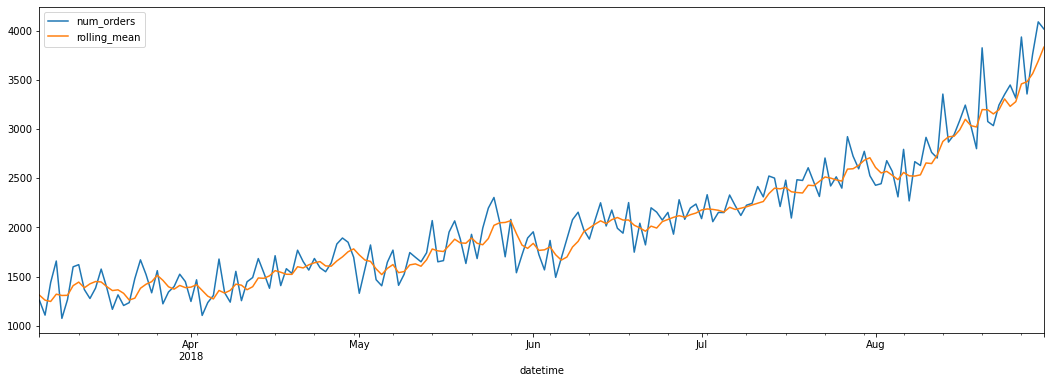

In [21]:
df_new[['num_orders', 'rolling_mean']].plot(figsize=(18, 6))
plt.show()

График стал более читабелен и из него можно сделать вывод, что присутствует тренд на увеличение количества заказов такси от месяца к месяцу.

 * Фактор месяца исходя из общего тренда играет роль, так как месяцы лета имеют тренд более высокого роста относительно весенних
 * Фактор дня играет также роль, так как имеет тенденцию также относительно месяца расти с течением времени
 * Фактор дня недели играет одну из самых важных ролей, потому что данные исходя из него сильно варьируются
 * Фактор часа играет самую важную роль, так как у нас прогнозирование на час вперед также на его фоне выделили сезонность ,где есть очень важные часы пиков и минимумов
 * Фактор lag нужен для определения интервала на котором обучается модель из целевого признака исходя из желаемого горизонта (если ресэмпл на день, а прогноз строим на неделю вперед ,то lag(7)) в нашем случае прогноз на час вперед ,то берем и lag(1)
 * Фактор rolling - это в чем-то схожий признак с lag, но как агрегирующая его функция также полезная для прогнозирования

Исходя из графиков определеям какие календарные признаки будем закладывать в модель:

 * Месяц и число (по графику тренда)
 * Часы (по графику сезонности)
 * День недели (по графику остатков)
 * Мы делаем прогноз на сутки, поэтому скользящее среднее равно 24 часам

Добавим также:

Отстающие значения;
Скользящее среднее;

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
   # data_new['month'] = data_new.index.month
   # data_new['day'] = data_new.index.day
    data_new['hour'] = data_new.index.hour
    data_new['dayofweek'] = data_new.index.dayofweek
    

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
    train = train.dropna()
    
    features_train = train.drop('num_orders',axis=1)
    features_test = test.drop('num_orders',axis=1)
    target_train = train['num_orders']
    target_test = test['num_orders']

    model = LinearRegression()
    rsme = -cross_val_score(model, features_train, target_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5)).mean()
    print(f'RSME = {rsme.round(2)} при lag = {max_lag}')
    return data_new


In [23]:
lags_list=[1,3,6,12,24]
data_temp =[]
df_new = df.copy()
for i in range(len(lags_list)):
    data_temp.append(make_features(df_new, lags_list[i], 24))
    display(data_temp[i].head())

RSME = 31.79 при lag = 1


,num_orders,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN
2018-03-01 02:00:00,71,2,3,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,NaN


RSME = 31.71 при lag = 3


,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,NaN


RSME = 31.73 при lag = 6


,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN


RSME = 31.61 при lag = 12


,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


RSME = 27.14 при lag = 24


,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
train, test = train_test_split(data_temp[4], shuffle=False, test_size=0.1)
train = train.dropna()
    
X_train = train.drop('num_orders',axis=1)
X_test = test.drop('num_orders',axis=1)
y_train = train['num_orders']
y_test = test['num_orders']
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(3950, 27) (442, 27) (3950,) (442,)


Определим функцию для построения графиков

In [25]:
sns.set(rc={'figure.figsize':(15,4)})

def lineplot(data, title):
    data.plot()
    plt.title(title)
    plt.show()

Разделим данные на трендовую, сезонную и шумовую состовляющие и построим соответствующие графики

In [26]:
decomposed = seasonal_decompose(df)

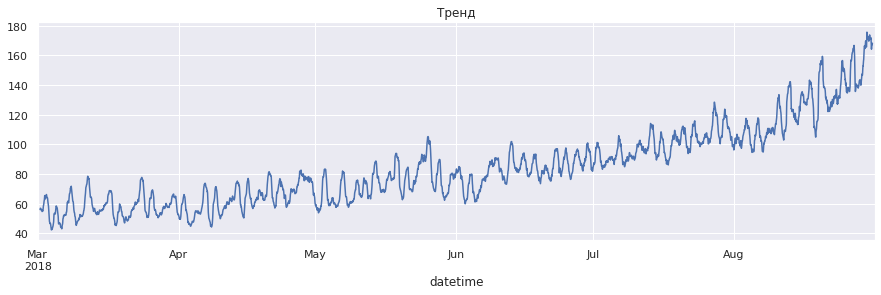

In [27]:
lineplot(decomposed.trend, 'Тренд')

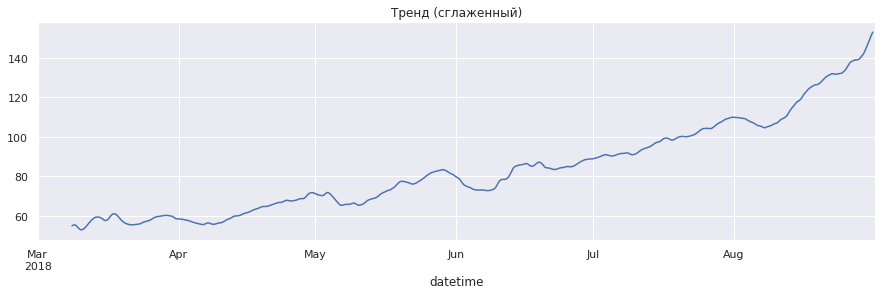

In [28]:
decomposed_shifted = decomposed.trend.shift()
smoothed_trend = decomposed_shifted.rolling(24*7, closed='left').mean()

lineplot(smoothed_trend, 'Тренд (сглаженный)')

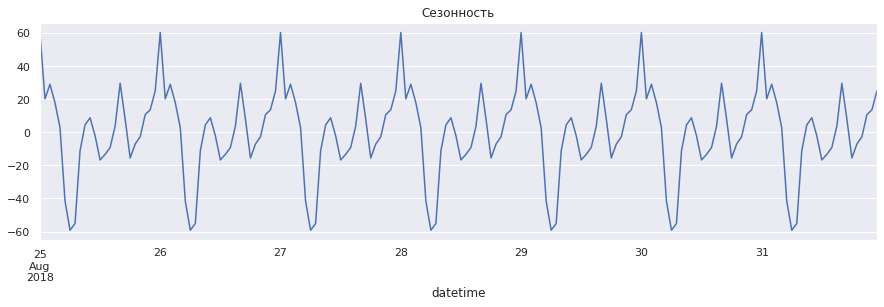

In [29]:
lineplot(decomposed.seasonal.tail(24*7), 'Сезонность')

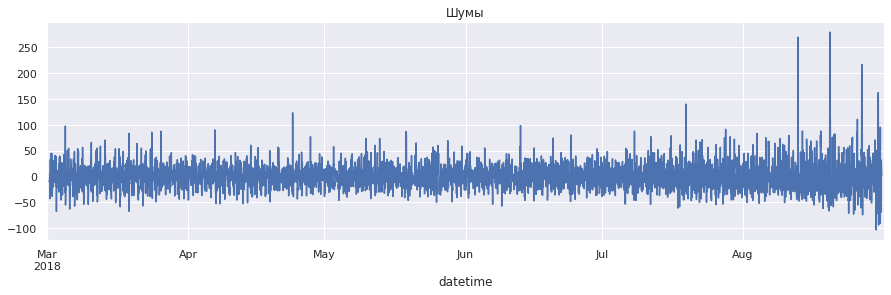

In [30]:
lineplot(decomposed.resid, 'Шумы')

Выводы:
* Наблюдается тренд равномерного роста заказов с периодическими небольшими падениями
* Присутствует сезонность по дням - спад ночью, рост с утра и днем, пик к вечеру

## Обучение

In [31]:
res=[]
res_test=[]

Произведем обученине моделей. Для подбора параметров используем инструмент GridSearchCV. Параметры моделей заранее подобраны таким образом, чтобы время обучения было минимальным при рассчитанной минимальной RSME. Для сокращения времени проверки кода, в графе подбор параметров уже указаны лучшие варианты из найденных

Начинаем с метода Дерево решений:

### DecisionTreeRegressor

In [32]:
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(20,30)
}
gsearch = GridSearchCV(model_dt, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
dt_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-dt_model.best_score_} при параметрах {dt_model.best_params_}')
res.append([(-dt_model.best_score_), dt_model.best_params_])

Лучшая RMSE: 28.78623809515445 при параметрах {'max_depth': 15, 'min_samples_leaf': 27}


### RandomForestRegressor

In [33]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(2,3)
}
gsearch = GridSearchCV(model_rf, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
gb_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-gb_model.best_score_} при параметрах ,{gb_model.best_params_}')
res.append([(-gb_model.best_score_), gb_model.best_params_])

Лучшая RMSE: 25.327187988593003 при параметрах ,{'max_depth': 15, 'min_samples_leaf': 2}


### GradientBoostingRegressor

In [34]:
model_gb = GradientBoostingRegressor()
param_grid = {
        'n_estimators' : range(80, 81, 1),
        'max_depth' : range(5, 6, 1),
        'verbose' : [0],
        'random_state' : [12345] 
        }

gsearch = GridSearchCV(model_gb, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
rf_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-rf_model.best_score_} при параметрах ,{rf_model.best_params_}')
res.append([(-rf_model.best_score_), rf_model.best_params_])

Лучшая RMSE: 25.1644128853596 при параметрах ,{'max_depth': 5, 'n_estimators': 80, 'random_state': 12345, 'verbose': 0}


### LightGBMRegressor

In [35]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE, n_jobs=2)

param_grid = {
    "max_depth" : range(11,12),
    "n_estimators" : range(56,57)
}

gsearch = GridSearchCV(model_lgbm, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
lgb_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-lgb_model.best_score_} при параметрах ,{lgb_model.best_params_}')
res.append([(-lgb_model.best_score_), lgb_model.best_params_])

Лучшая RMSE: 25.02408033835406 при параметрах ,{'max_depth': 11, 'n_estimators': 56}


### CatBoostRegressor

In [36]:
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)

param_grid = {
    "n_estimators": [500],
    'depth': [5]
}

gsearch = GridSearchCV(model_catboost, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
catboost_model = gsearch.fit(X_train,y_train)
print(f'Лучшая RMSE: {-catboost_model.best_score_} при параметрах ,{catboost_model.best_params_}')
res.append([(-catboost_model.best_score_), catboost_model.best_params_])

Лучшая RMSE: 24.175360896857132 при параметрах ,{'depth': 5, 'n_estimators': 500}


Cравним RSME, проведя кроссвалидацию на обучающей выборке по каждой из рассматриваемых моделей:

In [37]:
result = pd.DataFrame(data=res, columns=['rmse', 'optimal_parameters']).rename(index={0: 'DecisionTree', 1: 'RandomForest', 2: 'GradientBoosting', 3: 'LightGBM', 4: 'CatBoost'})
display(result)

,rmse,optimal_parameters
DecisionTree,28.786238,"{'max_depth': 15, 'min_samples_leaf': 27}"
RandomForest,25.327188,"{'max_depth': 15, 'min_samples_leaf': 2}"
GradientBoosting,25.164413,"{'max_depth': 5, 'n_estimators': 80, 'random_s..."
LightGBM,25.024080,"{'max_depth': 11, 'n_estimators': 56}"
CatBoost,24.175361,"{'depth': 5, 'n_estimators': 500}"


Таким образом мы получили минимальную метрику RSME = 24.1753 при обучении модели методом CatBoost.

## Тестирование

Проведем финальное тестирование, и определим подходит ли полученный RSME под критерии заказчика. В качестве лучшей модели будем использовать CatBoostRegressor c параметрами{'depth': 5, 'n_estimators': 500}

In [38]:
def importance(model,features):
    features = features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(20, 20))
    plt.title('Важность признаков')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

In [39]:
start = time.time()
best_model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0, depth=5, n_estimators=500)
best_model_catboost.fit(X_train, y_train)
end = time.time()
time_catboost = round(end-start,2)

In [40]:
start = time.time()
predict_catboost = best_model_catboost.predict(X_test)
end = time.time()
time_catboost_predict = round(end-start,2)

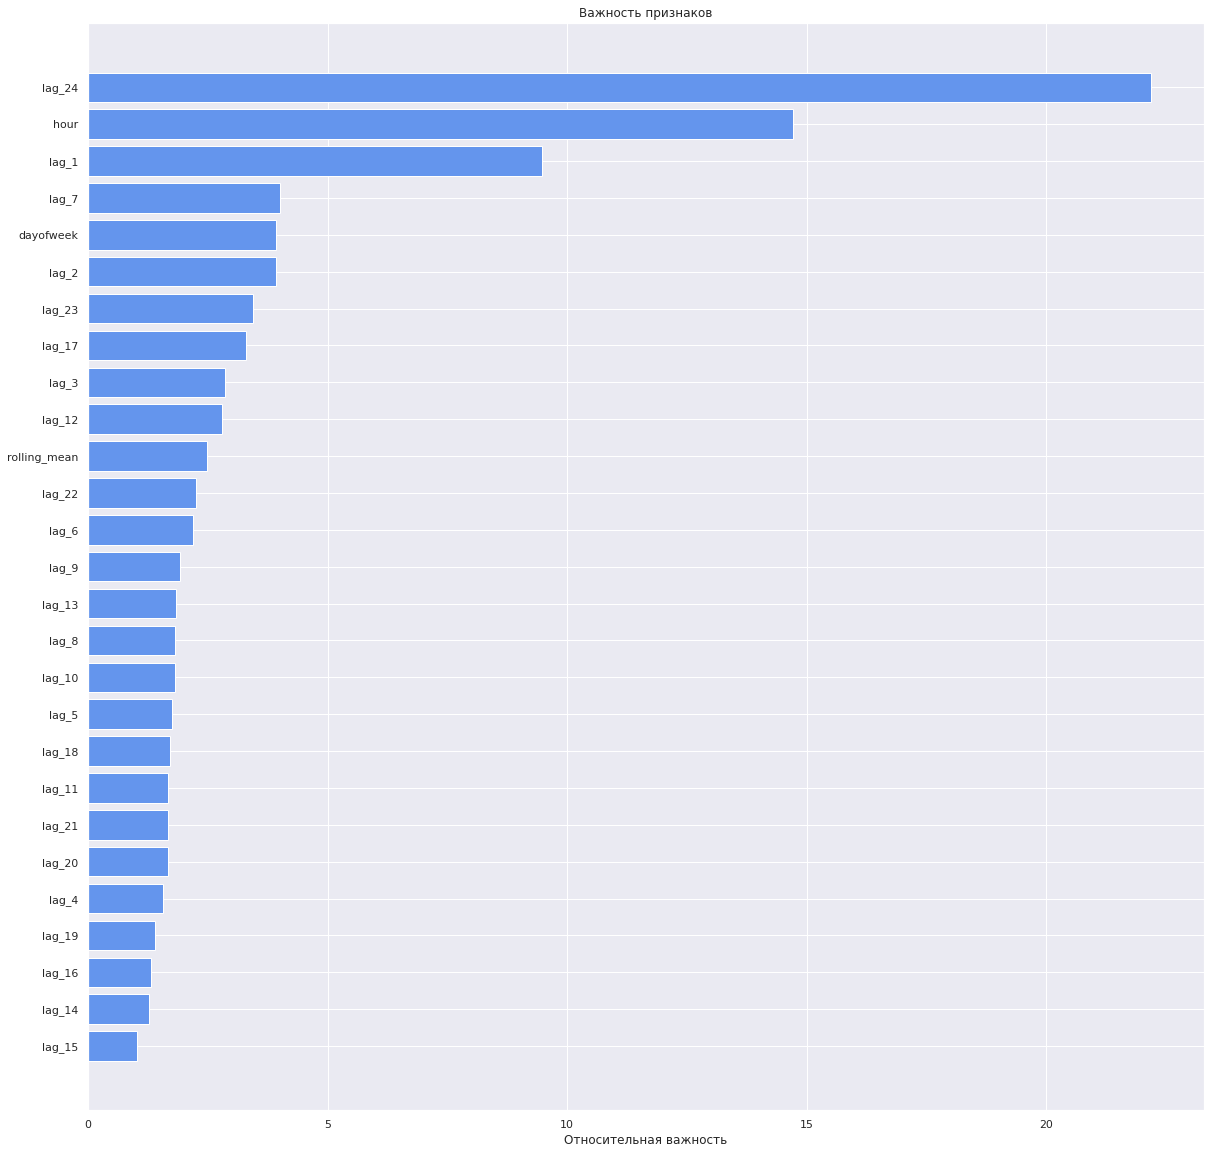

,Относительная важность
lag_24,22.189720
hour,14.725354
lag_1,9.486451
lag_7,4.017295
dayofweek,3.933485
lag_2,3.928316
lag_23,3.439829
lag_17,3.289858
lag_3,2.867095
lag_12,2.794144


In [41]:
importance(best_model_catboost, X_test)

In [42]:
catboost_best_rmse = mean_squared_error(y_test, predict_catboost,squared = False)
print('RMSE модели CatBoostRegressor равна:', catboost_best_rmse.round(2))

RMSE модели CatBoostRegressor равна: 40.02


In [43]:
model_scores = pd.DataFrame(data=[
            ('СatBoostRegressor', -catboost_model.best_score_, catboost_best_rmse, time_catboost, time_catboost_predict)], 
            columns=['Рекомендуемая модель', 'RMSE на обучающей выборке', 'RMSE на тестовой выборке', 'Скорость обучения, сек', 'Скорость предсказания, сек'])
model_scores = model_scores.style.hide_index()
model_scores  

Рекомендуемая модель,RMSE на обучающей выборке,RMSE на тестовой выборке,"Скорость обучения, сек","Скорость предсказания, сек"
СatBoostRegressor,24.175361,40.021539,2.350000,0.000000


Визуализация предсканий по лучшей модели:

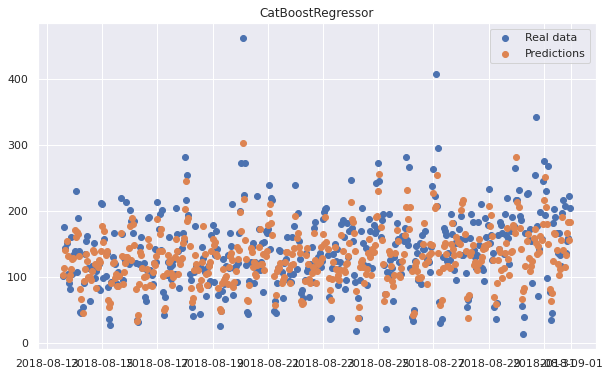

In [44]:
prediction_list = [predict_catboost]
model_list = ['CatBoostRegressor']
for pred in range(1):
    plt.figure(figsize=(10, 6)) 
    plt.scatter(y=y_test, x=y_test.index, label='Real data')
    plt.scatter(y=prediction_list[pred], x=y_test.index, label='Predictions')
    plt.legend(loc='upper right')
    plt.title(model_list[pred])
    plt.show()

В ходе проекта были обработаны данные о заказах такси.

Для прогноза количества заказов такси были построены 5 моделей предсказания. Самой эффективной моделью, которая показала минимальную метрику RSME(40,02) является модель градиентного бустинга библиотеки CatBoost c параметрами {'depth': 5, 'n_estimators': 500}, о чем свидетельствует финальный график, на котором точки предсказание и реальных данных хорошо расположены очень близко друг к другу.

Важными для модели признаками оказались

 * lag_24,
 * hour,
 * lag_1


Требование о значении метрики RMSE (не более 48) выполнено.